# GRANAD at a glance

GRANAD simulates electronic and optical properties of 2D material nanoflakes and heterostructures.
It is based on the single-electron tight-binding approximation and the master equation formalism that allows one to capture the time-resolved response to electromagnetic illumination.
For details of the framework and additional examples see [journal reference].
The online documentation provides a guideline for GRANAD's functionalities and usage examples.
Below, we begin with a quick summary of the most essential features: we list example static and dynamic quanitites that can be evaluated in GRANAD. For a step-by-step, more detailed introduction see the following documentation sections.

## Static quantities
In the example below, a triangular armchair-edged graphene nanoflake is created of the approximate size of 10 Angström.
First, we display the amplitudes for electron distribution over the flake sites in a selected eigenstate (amplitude ditribution in the SITE basis).
Next, the energy landscape of the single-particle tight-binding Hamiltonian in the nearest-neighbor approximation is shown. Colors encode the electronic population distribution among the eigenstates, i.e., in the ENERGY basis.

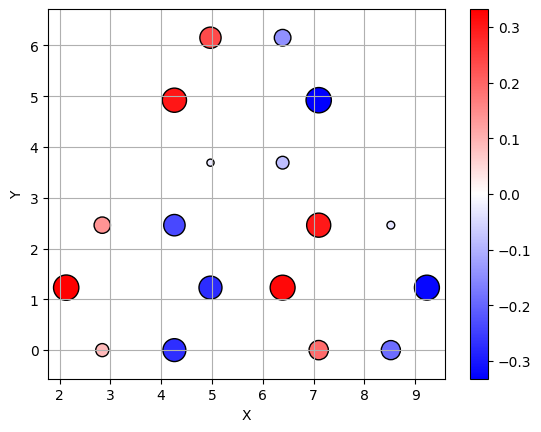

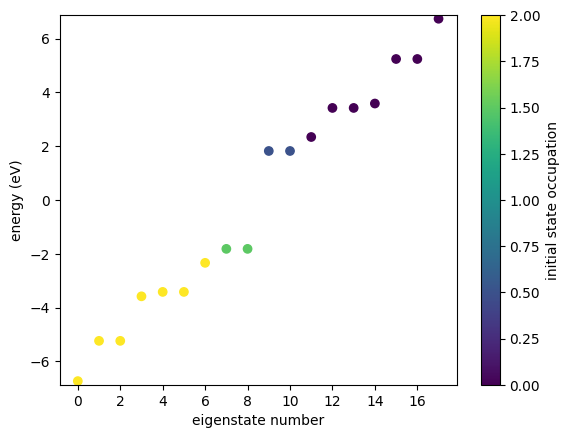

pz hopping between 0th and 2nd site 0j
0-th site occupation in SITE basis (0.05555555555555561+0j)
homo occupation in ENERGY basis (0.08333333333333326+0j)


HOMO-LUMO x-dipole (-1.0318472612379848+0j)


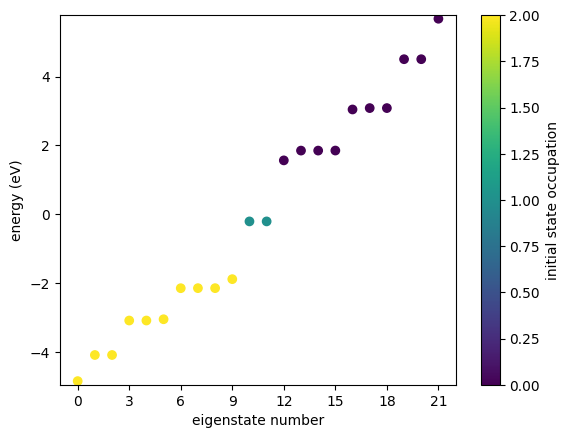

In [1]:
from granad import *
graphene = MaterialCatalog.get("graphene") # MaterialCatalog.available() lists all materials

flake = graphene.cut_flake(Triangle(10, armchair = True)) # more shapes available or define arbitrary polygons
flake.show_2d( display = flake.eigenvectors[:, flake.homo] ) # electron amplitudes in the single-particle HOMO state
flake.set_excitation(from_state = flake.homo, to_state = flake.lumo + 1, excited_electrons = 1) # N-electron initial state is set with a single electron excited from the homo to the lumo+1 level; by default, GRANAD sets the number of p_z electrons in graphene to be equal to the number of atomic sites. In case of degeneracy, GRANAD distributes electrons equally among states of the same energy.
flake.show_energies() # energies

# examples of physical quantities
print("pz hopping between 0th and 2nd site", flake.hamiltonian[0,2])
print("0-th site occupation in SITE basis", flake.initial_density_matrix.diagonal()[0])
print("homo occupation in ENERGY basis", flake.initial_density_matrix_e.diagonal()[flake.homo])  # adding "_e" to the names observables gives access to their elements in the energy basis
print("HOMO-LUMO x-dipole", flake.dipole_operator_e[0, flake.homo, flake.lumo]) # 0th, i.e. x-component of the dipole moment element between the HOMO and LUMO states

# customization
onsite, nn, nnn = [0, -2., 0.1] # This fragment defines the tight-binding Hamiltonian elements: [onsite, nearest-neighbor, next-nearest-neighbor, etc.] - you can define a longer list to include hopping among more distant neighbors
new_hoppings = [onsite, nn, nnn]
custom_graphene = MaterialCatalog.get("graphene", hoppings = new_hoppings) # pass your own hoppings
flake = custom_graphene.cut_flake(Triangle(10))
flake.show_energies() # energies

## Dynamic Quantities

RHS compiled
RHS compiled


100.0 %


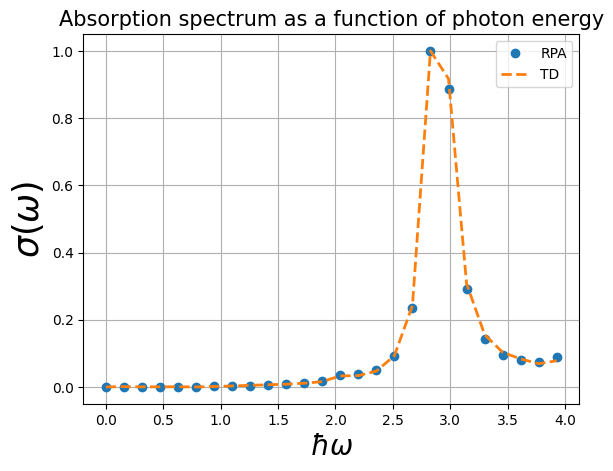

In [2]:
# Time-domain (TD) simulations provide time-resolved density matrix that represents the state of an average electron in an N-electron flake. Note that for graphene, the tight-binding approach in GRANAD accounts for p_z electrons. Similar limitations apply to other materials.
# Below, we illuminate the flake with a spectrally-broad pulse of electromagnetic radiation. The dynamics of the electronic density matrix is found based on the master equation, which in the example below is used to evaluate the induced polarization as the expectation value of the time-dependent dipole moment. A Fourier transform provides the absorption spectrum.

# pulsed field
pulse = Pulse(
    amplitudes=[1e-5, 0, 0], frequency=2.3, peak=5, fwhm=2) # for details of Pulse-type illumination and GRANAD units, see the corresponding documentation sections

# time evolution
result = flake.master_equation(
    expectation_values = [ flake.dipole_operator ],  # compute expectation values of physical quantities
    end_time=40,
    relaxation_rate=1/10,
    illumination=pulse,
)
# spectral range where the absorption cross section should be computed:
omega_max = 4
omega_min = 0
p_omega = result.ft_output( omega_max, omega_min )[0] # polarization in the frequency domain
omegas_td, pulse_omega = result.ft_illumination( omega_max, omega_min ) # illuminating field in the frequency domain
absorption_td = jnp.abs( -omegas_td * jnp.imag( p_omega[:,0] / pulse_omega[:,0] ) ) # absorption cross section evaluated based on the time-domain simulation

# RPA
# GRANAD provides another method to evaluate the absorption cross section , based on the random phase approximation, as detailed in  [Thongrattanasiri et al.](https://pubs.acs.org/doi/10.1021/nn204780e)
omegas_rpa = omegas_td
polarizability = flake.get_polarizability_rpa(
    omegas_rpa,
    relaxation_rate = 1/10,
    polarization = 0, 
    hungry = 2 )
absorption_rpa = jnp.abs( polarizability.imag * 4 * jnp.pi * omegas_rpa )

# Below, absorption cross sections obtained with the two methods are compared.
import matplotlib.pyplot as plt
plt.plot(omegas_rpa, absorption_rpa / jnp.max(absorption_rpa), 'o', linewidth=2, label = 'RPA')
plt.plot(omegas_td, absorption_td / jnp.max(absorption_td), linewidth=2, ls = '--', label = 'TD' ) 
plt.xlabel(r'$\hbar\omega$', fontsize=20)
plt.ylabel(r'$\sigma(\omega)$', fontsize=25)
plt.title('Absorption spectrum as a function of photon energy', fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

# Miscellenia

All tutorials as [jupyter files](https://github.com/GRANADlauncher/granad/tree/gh-pages/tutorials).